In [2]:
import sys
sys.path.append('..')

In [3]:
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# TSP specific
from library.problems.tsp import TSPHillClimbingSolution, TSPSASolution, TSPGASolution
from library.problems.data.tsp_data import distance_matrix

# Optimization algorithms
from library.algorithms.hill_climbing import hill_climbing
from library.algorithms.simulated_annealing import simulated_annealing
## GA specific
from library.algorithms.genetic_algorithms.algorithm import genetic_algorithm
from library.algorithms.genetic_algorithms.mutation import swap_mutation, inversion_mutation
from library.algorithms.genetic_algorithms.crossover import cycle_crossover, swap_crossover
from library.algorithms.genetic_algorithms.selection import fitness_proportionate_selection

# Experimental Analysis - Solving TSP with Optimization Algorithms

An experimental study is used to **compare the performance of different optimization algorithms on a specific optimization problem**.

According to the **No Free Lunch Theorem**, no single algorithm performs best across all optimization problems. This makes algorithm comparison essential.

Since most optimization (and machine learning) algorithms are non-deterministic, they can produce different results each time they are run. To ensure reliable conclusions, it's important to run each algorithm multiple times. Otherwise, observed performance differences may simply be due to random variation.

Statistically, running each configuration at least 30 times is recommended to obtain robust and trustworthy results.

## Compare Hill Climbing (HC), Simulated Annealing (SA) and Genetic Algorithms (GA)

Hill Climbing, Simulated Annealing, and Genetic Algorithms are optimization methods designed to search through large solution spaces to find the best possible answer—ideally the global optimum.

Each algorithm uses a different strategy to explore the search space:

- **Hill Climbing (HC)** follows a greedy approach. It explores neighboring solutions and always moves to the best one found. While simple and fast, it often gets stuck in local optima.
- **Simulated Annealing (SA)** also explores neighbors, but unlike HC, it occasionally accepts worse solutions in order to escape local optima. This makes it more flexible than HC.
- **Genetic Algorithms (GA)** work differently. Instead of improving a single solution, they maintain a population of solutions and use genetic-inspired operations (like crossover and mutation) to evolve better ones over time.

These algorithms also differ in how long they run:
- **HC** typically stops when it reaches a local optimum. Its number of iterations can vary between runs.
- **SA** and **GA**, on the other hand, usually run for a fixed number of iterations - called **generations** in GA.

It is important not to compare the performance of these algorithms against the iterations. For example, running SA for _m_ iterations isn't equivalent to running GA for _m_ generations, because their computational costs are different. SA evaluates just one solution per iteration, while GA evaluates N solutions per generation (where N is the population size).

To fairly compare their performance, we can instead look only ate the final best individual found by each of these algorithms:

1. Run each algorithm at least 30 times independently.
2. Record the best solution found at the end of each run.
3. Compare the results using statistical measures (like average best fitness, standard deviation, etc.) and plots (eg.: boxplots)

This way, we get a more reliable picture of how well each algorithm performs.

### Run the algorithms

For this experiment, we’ll use:

- **HC** with a "consecutive city swap" neighborhood.
- **SA** with the same neighborhood, and hyperparameters:
    - C=1, L=10, H=0.1, max iterations=100
- **GA** with:
    - Swap mutation (probability: 0.8)
    - Cycle crossover (probability: 0.9)
    - Population size: 50
    - Generations: 100
    - Elitism: Yes

The SA hyperparameters and the GA mutation/crossover probabilities were selected based on intuition. Similarly, the population size, number of generations and use of elitism on the GA were chosen to balance optimization performance and runtime. The choice of swap mutation and cycle crossover was arbitrary for the purpose of this example.

These hyperparameters are not tuned for best performance, and most likely are not optimal. However, since the goal here is simply to demonstrate how to compare these different optimization strategies, these values are good enough to illustrate the process.

In [ ]:
POP_SIZE = 50
# Will save the fitness of the best individual in the end of each of the 30 runs
hc_best_fitnesses = []
sa_best_fitnesses =[]
ga_best_fitnesses = []

for run_nr in range(30):
    hc_best_solution = hill_climbing(
        initial_solution=TSPHillClimbingSolution(distance_matrix=distance_matrix, starting_idx=0),
        maximization=False
    )
    sa_best_solution = simulated_annealing(
        initial_solution=TSPSASolution(distance_matrix=distance_matrix, starting_idx=0),
        maximization=False,
        C=1,
        L=10,
        H=0.1,
        max_iter=100
    )
    ga_best_solution, _ = genetic_algorithm(
        initial_population=[
            TSPGASolution(
                distance_matrix=distance_matrix,
                starting_idx=0,
                mutation_function=swap_mutation,
                crossover_function=cycle_crossover
            ) for _ in range(POP_SIZE)
        ],
        max_gen=100,
        selection_algorithm=fitness_proportionate_selection,
        xo_prob=0.8,
        mut_prob=0.9,
        elitism=True
    )

    hc_best_fitnesses.append(hc_best_solution.fitness())
    sa_best_fitnesses.append(sa_best_solution.fitness())
    ga_best_fitnesses.append(ga_best_solution.fitness())

To visualize the results we can use boxplots.

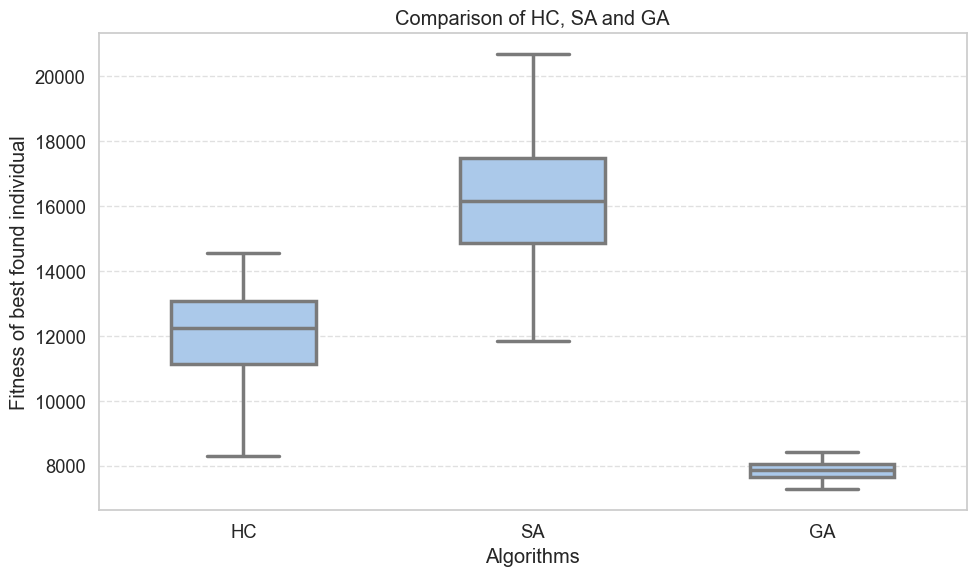

In [4]:
# Create a DataFrame in long format
df = pd.DataFrame({
    'value': hc_best_fitnesses + sa_best_fitnesses + ga_best_fitnesses,
    'group': ['HC'] * len(hc_best_fitnesses) + ['SA'] * len(sa_best_fitnesses) + ['GA'] * len(ga_best_fitnesses)
})

# Set a beautiful theme
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)

# Create the plot
plt.figure(figsize=(10, 6))
ax = sns.boxplot(x='group', y='value', data=df, width=0.5, linewidth=2.5, fliersize=4)

# Titles and labels
plt.title('Comparison of HC, SA and GA')
plt.xlabel('Algorithms')
plt.ylabel('Fitness of best found individual')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


We can conclude that the genetic algorithm finds individuals with better fitness (in TSP lower is better) and more consistently.

Simulated annealing seems to be the worst performing algorithm with the worst median best individuals found. It is very very liekly that these results are due to poor parameter tuning, and it would be worth to explore the impact of varying C, L and H on the performance of this algorithm.


From the boxplot, we can conclude that the Genetic Algorithm outperforms both Hill Climbing and Simulated Annealing in solving the TSP problem. Since lower fitness values are better, GA not only finds better solutions on average but also shows more consistent performance across multiple runs (smaller variance).

Simulated Annealing appears to be the worst performer, showing the highest median fitness and the largest variability. However, it's important to note that these results are likely affected by suboptimal hyperparameter choices. In this case, the values for parameters C, L, and H were set randomly without tuning. Exploring different configurations for these parameters could significantly improve SA’s results.

Hill Climbing performs moderately well, but is clearly outclassed by GA in both performance and stability.

As a good next step, a hyperparameter tuning would be valuable, especially for SA, to better understand how hyperparameters affect outcomes and possibly unlock better performance.

## Analyse GA in depth: Impact of hyperparameters

There are two common ways to compare the performance of a Genetic Algorithm under different hyperparameter settings:
- **Fitness over generations** – tracking how solutions improve throughout the generations
- **Fitness vs. computational effort** – evaluating performance relative to resource usage (like time, or number of fitness evaluations)

In this notebook, we'll focus on the first approach: **fitness over generations**. To ensure a fair comparison between different GA configurations, we'll keep the **population size** and **number of generations** constant across all experiments. This way, we guarantee that each setup performs a similar amount of work, making the results directly comparable.

As a starting point, we’ll fix some hyperparameters - specifically the crossover and mutation probabilities - based on intuition. This allows us to explore the influence of other settings while keeping these factors stable. We'll also always use fitness proportionate selection, as it it the only one implemented on the library. Finally, the number of generations and population size will be set to 200 and 100, respectively.

Here is the set of different GA configurations that will be tested:

| GA configuration | Crossover | Mutation | xo_prob | mut_prob | Elistim | Selection Algorithm |
| - | - | - | - | - | - | - |
| 1 | Cycle crossover | Swap mutation | 0.8 | 0.9 | Yes | Fitness proportionate |
| 2 | Cycle crossover | Swap mutation | 0.8 | 0.9 | No | Fitness proportionate |
| 3 | Cycle crossover | Inversion mutation | 0.8 | 0.2 | Yes | Fitness proportionate |
| 4 | Cycle crossover | Inversion mutation | 0.8 | 0.2 | No | Fitness proportionate |
| 5 | Swap crossover | Swap mutation | 0.8 | 0.9 | Yes | Fitness proportionate |
| 6 | Swap crossover | Swap mutation | 0.8 | 0.9 | No | Fitness proportionate |
| 7 | Swap crossover | Inversion mutation | 0.8 | 0.2 | Yes | Fitness proportionate |
| 8 | Swap crossover | Inversion mutation | 0.8 | 0.2 | No | Fitness proportionate |


**Tip:** It's highly recommended to save the results of each configuration (and even each run) as they are generated. This helps avoid re-running the same experiments multiple times, saving both time and computational resources.

**Note:** The following cells may take approximately 9 minutes to execute.

In [ ]:
POP_SIZE = 100
GENERATIONS = 200

grid_params = {
    "crossover": [
        {
            "function": cycle_crossover,
            "xo_prob": 0.8
        },
        {
            "function": swap_crossover,
            "xo_prob": 0.8
        }
    ],
    "mutation": [
        {
            "function": swap_mutation,
            "mut_prob": 0.8
        },
        {
            "function": inversion_mutation,
            "mut_prob": 0.2
        }
    ],
    "elitism": [True, False]
}

fitness_dfs = {}

# Generate all combinations of the grid parameters
grid = list(itertools.product(grid_params["crossover"], grid_params["mutation"], grid_params["elitism"]))

for crossover_cfg, mutation_cfg, elitism in grid:
    # Create empty dataframe for each configuration
    # Columns have the fitness in each generation, rows will have results for each run
    df = pd.DataFrame(columns=range(GENERATIONS)) # Shape will be 30 x 200

    # Get crossover and mutation functions and probabilities from the grid
    crossover_function = crossover_cfg["function"]
    xo_prob = crossover_cfg["xo_prob"]
    mutation_function = mutation_cfg["function"]
    mut_prob = mutation_cfg["mut_prob"]

    config_results = []

    # Run for 30 times
    for run_nr in range(30):
        _, fitness_over_gens = genetic_algorithm(
            initial_population=[
                TSPGASolution(
                    distance_matrix=distance_matrix,
                    starting_idx=0,
                    mutation_function=mutation_function,
                    crossover_function=crossover_function
                ) for _ in range(POP_SIZE)
            ],
            max_gen=GENERATIONS,
            selection_algorithm=fitness_proportionate_selection,
            xo_prob=xo_prob,
            mut_prob=mut_prob,
            elitism=elitism
        )
        config_results.append(fitness_over_gens)

        df.loc[run_nr] = fitness_over_gens

    # Create a label for the configuration
    config_label = (
        f"{crossover_function.__name__}{xo_prob}_"
        f"{mutation_function.__name__}{mut_prob}_elitism={elitism}"
    )

    # Save configuration results in the dictionary
    fitness_dfs[config_label] = df


Now we have the results saved as pandas dataframes for each configuration.

In [41]:
print(list(fitness_dfs.keys()))

['cycle_crossover0.8_swap_mutation0.8_elitism=True', 'cycle_crossover0.8_swap_mutation0.8_elitism=False', 'cycle_crossover0.8_inversion_mutation0.2_elitism=True', 'cycle_crossover0.8_inversion_mutation0.2_elitism=False', 'swap_crossover0.8_swap_mutation0.8_elitism=True', 'swap_crossover0.8_swap_mutation0.8_elitism=False', 'swap_crossover0.8_inversion_mutation0.2_elitism=True', 'swap_crossover0.8_inversion_mutation0.2_elitism=False']


Let's check the results for cycle crossover (probability 0.8), swap mutation (probability 0.8) and use of elitism.

In [91]:
fitness_dfs["cycle_crossover0.8_swap_mutation0.8_elitism=True"]

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,12079,9960,9960,9960,9185,9185,9185,9185,9185,9185,...,7343,7343,7343,7343,7343,7343,7343,7343,7343,7343
1,10015,10015,10015,10015,10015,10015,10015,10015,9588,9588,...,7815,7815,7815,7815,7815,7815,7815,7815,7815,7815
2,10797,10797,10158,9337,9337,9337,9337,8332,8332,8332,...,7668,7668,7668,7668,7668,7668,7668,7668,7668,7668
3,10877,10877,10877,10877,9600,9600,9600,9600,9600,9600,...,7701,7701,7701,7701,7701,7701,7701,7701,7701,7701
4,11404,10501,10181,10181,10181,10181,9911,9418,9418,9418,...,7653,7653,7653,7653,7653,7653,7653,7653,7569,7569
5,11280,11280,10601,10165,10165,10165,9741,9741,9741,9741,...,7586,7586,7586,7586,7586,7586,7586,7586,7586,7586
6,10506,10240,10240,10240,10240,10240,9756,9756,9209,8872,...,7701,7701,7701,7701,7701,7701,7701,7701,7701,7701
7,9443,9443,9443,9443,8698,8698,8455,8455,8455,8455,...,8120,8120,8120,8120,8120,8120,8120,8120,8120,8120
8,10840,10840,10840,10840,9568,9568,9568,9152,9144,9144,...,7581,7581,7581,7581,7581,7581,7581,7581,7581,7581
9,10161,10161,10161,10161,10161,10161,10161,10095,9726,9726,...,7619,7619,7619,7619,7619,7619,7619,7619,7619,7619


We now have the results organized by run and generation, which allows us to visualize the performance of the algorithm throughout the evolution. A great way to do this is by using line plots, where each line shows either the **mean** or the **median** fitness of the best individual across runs at each generation.

Let’s plot both metrics:
- The **mean** gives us an overall average trend.
- The **median** provides a more robust view, as it’s less sensitive to outlier runs that may have performed unusually well or poorly by chance.

In [7]:
def plot_fitness_over_gen(fitness_dfs: dict[str, pd.DataFrame]):
    """
    
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    handles, labels = [], []

    for config_name, df in fitness_dfs.items():
        mean_fitness = df.mean(axis=0)
        median_fitness = df.median(axis=0)
        
        line1, = axes[0].plot(mean_fitness.index, mean_fitness.values, label=config_name)
        axes[1].plot(median_fitness.index, median_fitness.values, label=config_name)

        handles.append(line1)
        labels.append(config_name)

    axes[0].set_title("Mean Fitness Across Generations")
    axes[1].set_title("Median Fitness Across Generations")

    for ax in axes:
        ax.set_xlabel("Generation")
        ax.set_ylabel("Fitness")
        ax.grid(True)

    # Shared boxed legend below
    legend = fig.legend(
        handles,
        labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.15),
        ncol=2,
        frameon=True,
        borderpad=1
    )

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()

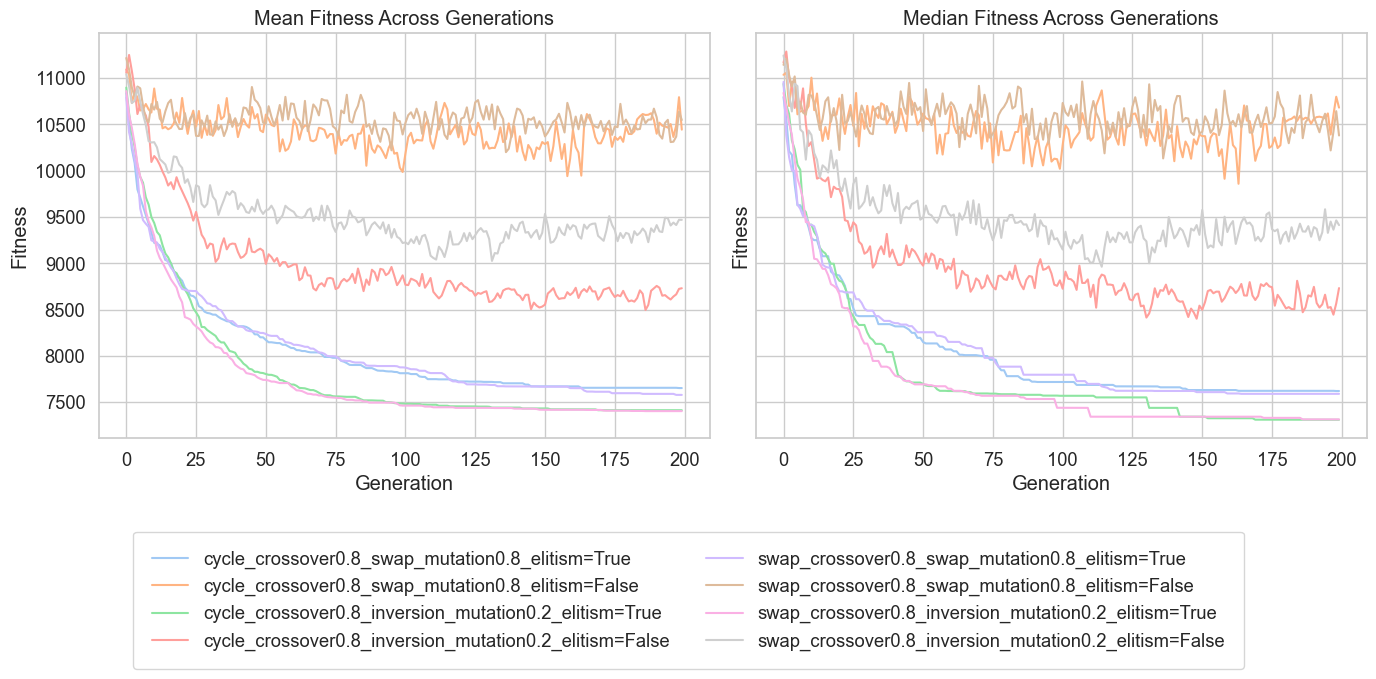

In [93]:
plot_fitness_over_gen(fitness_dfs)

From the plot, two main observations immediately stand out:

- Configurations without elitism consistently perform worse overall.
- Their fitness curves are also much more unstable, showing a lot of ups and downs throughout the generations.

At the early stages of evolution, differences between configurations aren’t very noticeable. But as evolution progress, it becomes more clear that the **two best-performing configurations** (green and pink lines) **both use inversion mutation**. This suggests that inversion mutation may be more effective than swap mutation for this particular problem.

In fact, even among the configurations **without elitism**, those using inversion mutation still outperform those using swap. Although their overall performance is lower, this pattern reinforces the potential advantage of inversion mutation in this context.

Finally,  the best-performing configuration appears to be `swap crossover + inversion mutation + elitism` (pink line), though it’s quite similar to `cycle crossover + inversion mutation + elitism` (green line).

In conclusion, the results suggest that the choice of crossover method has a relatively small impact on performance, while the mutation type and the use of elitism play a much larger role in the GA's ability to find good solutions.

### Isolating the Impact of Crossover and Mutation

We’ve collected results from 30 runs for each combination of hyperparameters. Now, let’s focus on understanding the isolated effect of individual hyperparameters, specifically, crossover and mutation strategies.

There are two common approaches to evaluate the influence of a single hyperparameter:

- **Approach 1: Aggregate raw runs**

    Group all runs that use a particular hyperparameter value and compute the median best fitness across those runs.
- **Approach 2: Aggregate by configuration**

    First calculate the median result for each configuration, and then take the median of those medians for the ones sharing the same hyperparameter value.

Both perspectives offer a useful analysis, so let's apply both methods and compare what they reveal.

**Approach 1**

In [ ]:
crossover_names = ["cycle_crossover", "swap_crossover"]
mutation_names = ["swap_mutation", "inversion_mutation"]

crossover_fit_dfs = {}
mutation_fit_dfs = {}

# Combine all isolated runs using a given crossover
for crossover_name in crossover_names:
    dfs_to_concat = []
    for df_name, df in fitness_dfs.items():
        if crossover_name in df_name:
            dfs_to_concat.append(df)

    crossover_fit_dfs[crossover_name] = pd.concat(dfs_to_concat, axis=0).reset_index(drop=True)

# Combine all isolated runs using a given mutation
for mutation_name in mutation_names:
    dfs_to_concat = []
    for df_name, df in fitness_dfs.items():
        if mutation_name in df_name:
            dfs_to_concat.append(df)
    mutation_fit_dfs[mutation_name] = pd.concat(dfs_to_concat, axis=0).reset_index(drop=True)


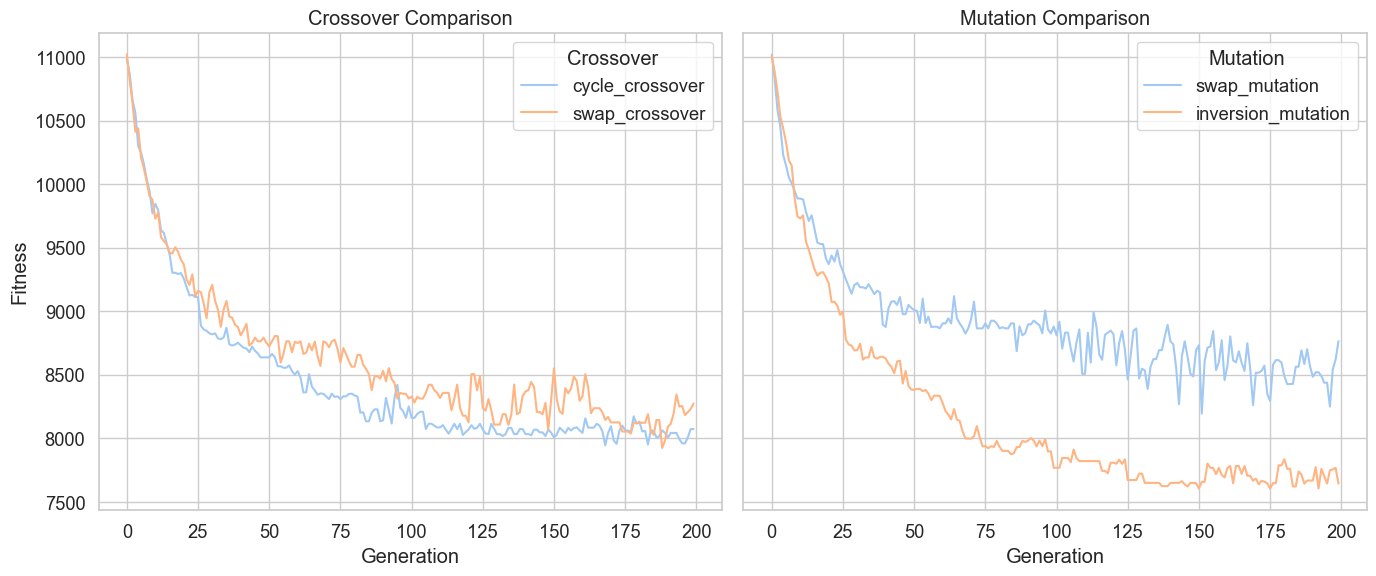

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot crossover results
for name, df in crossover_fit_dfs.items():
    mean_fitness = df.median(axis=0)
    axes[0].plot(mean_fitness.index, mean_fitness.values, label=name)

axes[0].set_title("Crossover Comparison")
axes[0].set_xlabel("Generation")
axes[0].set_ylabel("Fitness")
axes[0].legend(title="Crossover")
axes[0].grid(True)

# Plot mutation results
for name, df in mutation_fit_dfs.items():
    mean_fitness = df.median(axis=0)
    axes[1].plot(mean_fitness.index, mean_fitness.values, label=name)

axes[1].set_title("Mutation Comparison")
axes[1].set_xlabel("Generation")
axes[1].legend(title="Mutation")
axes[1].grid(True)

plt.tight_layout()
plt.show()


It looks like cycle crossover is generally better than swap mutation, and inversion muttaion is generally better than swap mutation.

However, it is not possible to define the strength of these claims without looking at the standard deviation bands or  performing a statistical test. That would be the next step!

It looks like **cycle crossover** yields better results than **swap crossover**, and **inversion mutation** outperforms **swap mutation** in this problem.

However, we should be cautious in drawing strong conclusions from visual analysis alone. To determine how reliable these differences are, we’d need to:

- Add confidence intervals or standard deviation bands to the plots, to visualize variability across runs
- Or even better, perform statistical tests to evaluate whether the observed differences are statistically significant

That would the logical next step in our analysis.

**Approach 2**

In [ ]:
crossover_names = ["cycle_crossover", "swap_crossover"]
mutation_names = ["swap_mutation", "inversion_mutation"]

crossover_medians = {k: [] for k in crossover_names}
mutation_medians = {k: [] for k in mutation_names}

for df_name, df in fitness_dfs.items():
    for crossover_name in crossover_names:
        if crossover_name in df_name:
            # Calculate median best fitness over generations for configuration using this crossover
            crossover_medians[crossover_name].append(df.median(axis=0).values)
    for mutation_name in mutation_names:
        if mutation_name in df_name:
            # Calculate median best fitness over generations for configuration using this mutation
            mutation_medians[mutation_name].append(df.median(axis=0).values)

# Compute final median curves (median of medians across configurations)
crossover_curves = {k: np.median(v, axis=0) for k, v in crossover_medians.items()}
mutation_curves = {k: np.median(v, axis=0) for k, v in mutation_medians.items()}

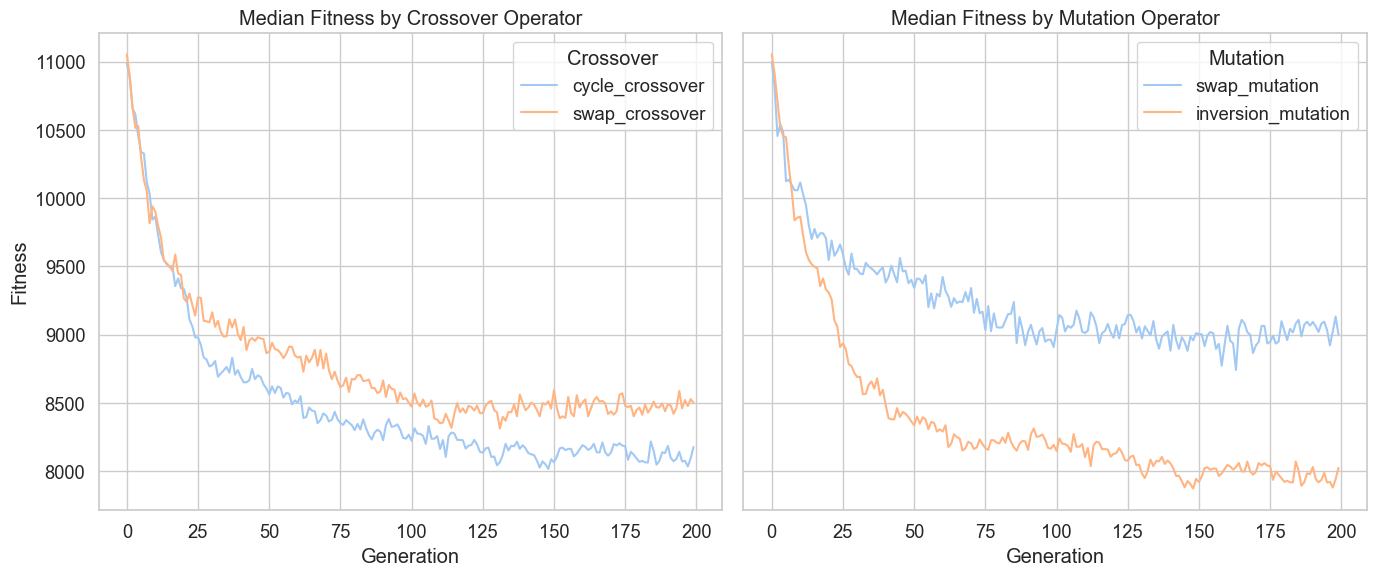

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot crossover
for name, curve in crossover_curves.items():
    axes[0].plot(range(len(curve)), curve, label=name)
axes[0].set_title("Median Fitness by Crossover Operator")
axes[0].set_xlabel("Generation")
axes[0].set_ylabel("Fitness")
axes[0].legend(title="Crossover")
axes[0].grid(True)

# Plot mutation
for name, curve in mutation_curves.items():
    axes[1].plot(range(len(curve)), curve, label=name)
axes[1].set_title("Median Fitness by Mutation Operator")
axes[1].set_xlabel("Generation")
axes[1].legend(title="Mutation")
axes[1].grid(True)

plt.tight_layout()
plt.show()


The results are quite similar to those of Approach 1: cycle crossover is better then swap crossover and inversion mutation is better than swap mutation.

Both approaches are valid for this type of analysis.

Interestingly, when analyzing the operators in isolation, it might seem that using cycle crossover with inversion mutation is the best choice. However, as we saw earlier, the combination of `swap crossover + inversion mutation + elitism` (represented by the pink line) actually performed better overall. This result, while likely not statistically different from the `cycle crossover + inversion mutation + and elitism combination` (green line), suggests that considering the full set of hyperparameters together is essential to get to the best solution.

**In other words, while analyzing each operator separately can help us understand their individual impacts, the best final solution comes from looking at the hyperparameters as a whole.**

#### Guidelines for more in depth analysis

- Analyse only the best perfoming configurations and compare them in more detail
- Use statistical tests to calculate the significance of performance differences between configurations.
- Speculate about the reason for those differences
- Assess the stability of the evolution by analysing the standard deviation of results across multiple runs.

#### Fine-tuning of hyperparameters

We didn't perform statistical tests to confirm if swap crossover + inversion mutation + elistim is significantly better than any of the other configurations. Nevertheless, we can proceed with it as our final genetic operator configuration and focus on optimizing other hyperparameters, such as crossover and mutation probabilities.

To do this, we'll use random search. We'll test one random value for the crossover and mutation probabilities between [0, 1/3], another between [1/3, 2/3], and a third between [2/3, 1]. This approach avoids bias from pre-defined fixed probabilities.

In total, we’ll test 9 different configurations (3 for crossover and 3 for mutation). Ideally, we’d test more values for each probability (5 or more), but for demonstration purposes, we’ll stick to these 9 configurations to keep things manageable.

In [17]:
grid_params = {
    "xo_prob": [random.uniform(0, 1/3), random.uniform(1/3, 2/3), random.uniform(2/3, 1)],
    "mut_prob": [random.uniform(0, 1/3), random.uniform(1/3, 2/3), random.uniform(2/3, 1)]
}

finetune_fitness_results = {}

for xo_prob in grid_params["xo_prob"]:
    for mut_prob in grid_params["mut_prob"]:
        config_results = []

        for run_nr in range(30):
            best_solution, _ = genetic_algorithm(
                initial_population=[
                    TSPGASolution(
                        distance_matrix=distance_matrix,
                        starting_idx=0,
                        mutation_function=inversion_mutation,
                        crossover_function=swap_crossover
                    ) for _ in range(POP_SIZE)
                ],
                max_gen=GENERATIONS,
                selection_algorithm=fitness_proportionate_selection,
                xo_prob=xo_prob,
                mut_prob=mut_prob,
                elitism=True
            )
            config_results.append(best_solution.fitness())

        # Create a label for the config
        config_label = f"xo_prob={round(xo_prob, 2)}_mut_prob={round(mut_prob, 2)}"
    
        finetune_fitness_results[config_label] = config_results

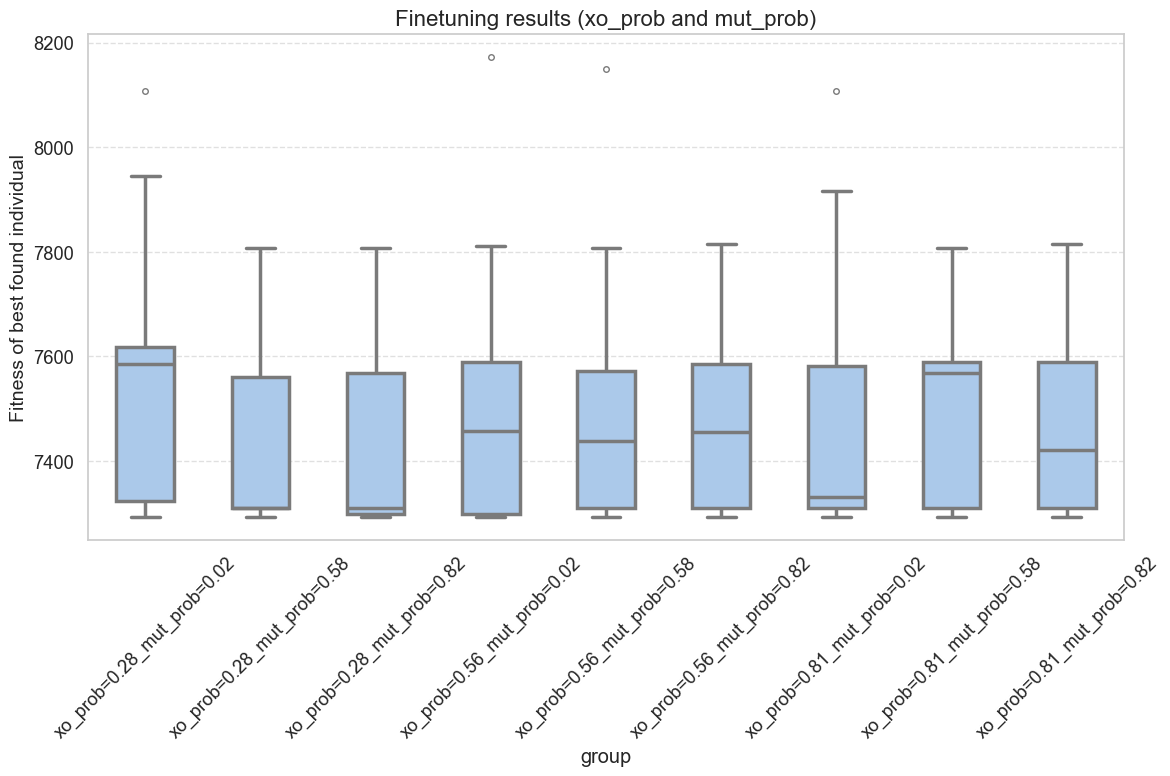

In [18]:
# Convert the results into a long-format DataFrame for Seaborn
data = []
for config_label, fitness_values in finetune_fitness_results.items():
    for value in fitness_values:
        data.append({
            'value': value,
            'group': config_label
        })

df_long = pd.DataFrame(data)

# Set a beautiful theme using Seaborn
sns.set_theme(style="whitegrid", palette="pastel", font_scale=1.2)

# Create the plot
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x='group', y='value', data=df_long, width=0.5, linewidth=2.5, fliersize=4)

# Titles and labels
plt.title('Finetuning results (xo_prob and mut_prob)', fontsize=16)
plt.ylabel('Fitness of best found individual', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


The results suggest that fine-tuning the crossover and mutation probabilities has a minimal impact on the overall performance of the GA when using inversion mutation and swap crossover.

Across all tested parameter combinations, the distribution of the best-found fitness values on the last generations remains quite similar, with overlapping interquartile ranges and close median values.

This indicates that the algorithm's performance is relatively stable and not highly sensitive to these hyperparameters. It also suggests that the chosen genetic operators are robust to parameter variations, or that other factors, such as population size, selection strategy, or problem-specific characteristics, may play a more significant role in optimization outcomes.

# Disclaimer!

This notebook presents some approaches to conduct an experimental analysis, but there are many other valid and effective methods for this type of analysis!

When performing experimental analysis, focus on what makes sense to you and aligns with the insights you gain as you go. In some cases, it may be worth exploring different angles or analyzing factors not covered here, especially if they could influence the performance of the algorithms for your specific problem.